# Get binders 
Script to sort data out and save files only containing binders

In [ ]:
import os

# List of all HLA alleles
hla_list = [
    "A0101", "A0201", "A0202", "A0203", "A0206", "A0301", "A1101", "A2301",
    "A2402", "A2403", "A2601", "A2902", "A3001", "A3002", "A3101", "A3301",
    "A6801", "A6802", "A6901", "B0702", "B0801", "B1501", "B1801", "B2705",
    "B3501", "B4001", "B4002", "B4402", "B4403", "B4501", "B5101", "B5301",
    "B5401", "B5701", "B5801"
]

threshold_nM = 0.426

for hla in hla_list:
    file_path = f"/Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/BioAlgoProject2025/data/AllFiles/{hla}/{hla}.dat"
    output_path = f"/Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/BioAlgoProject2025/data/PSSM/{hla}/{hla}_bind.dat"
    bind_count = 0

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    try:
        with open(file_path, "r") as infile, open(output_path, "w") as outfile:
            for line in infile:
                parts = line.strip().split()
                if len(parts) == 3:
                    try:
                        value = float(parts[1])
                        # Saving values that are above the threshold as a value of 1 is the strongest binding
                        if value > threshold_nM:
                            outfile.write(line)
                            bind_count += 1
                    except ValueError:
                        continue

        print(f"{hla}: {bind_count} strong binders saved to {output_path}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")


A0101: 103 strong binders saved to /Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/BioAlgoProject2025/data/PSSM/A0101/A0101_bind.dat
A0201: 1181 strong binders saved to /Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/BioAlgoProject2025/data/PSSM/A0201/A0201_bind.dat
A0202: 649 strong binders saved to /Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/BioAlgoProject2025/data/PSSM/A0202/A0202_bind.dat
A0203: 639 strong binders saved to /Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/BioAlgoProject2025/data/PSSM/A0203/A0203_bind.dat
A0206: 513 strong binders saved to /Users/mathildedue/Library/CloudStorage/OneD

## Split data into folds (nested 5 fold)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import os
from typing import List

# ------------------------
# Hobohm 1 Clustering
# ------------------------
def simple_seq_identity(a: str, b: str) -> float:
    dp = np.zeros((len(a)+1, len(b)+1), dtype=int)
    for i in range(len(a)+1):
        dp[i][0] = i
    for j in range(len(b)+1):
        dp[0][j] = j
    for i in range(1, len(a)+1):
        for j in range(1, len(b)+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + cost)
    edit_distance = dp[len(a)][len(b)]
    return 1 - edit_distance / max(len(a), len(b))

def hobohm1(seqs: List[str], cutoff: float = 0.3) -> np.ndarray:
    print(f"Clustering {len(seqs)} sequences using Hobohm 1 (identity cutoff = {cutoff})...")
    order = np.argsort([-len(s) for s in seqs])
    reps, clusters = [], np.full(len(seqs), -1, int)
    for idx in order:
        s = seqs[idx]
        for rep_id in reps:
            if simple_seq_identity(s, seqs[rep_id]) >= cutoff:
                clusters[idx] = clusters[rep_id]
                break
        else:
            clusters[idx] = len(reps)
            reps.append(idx)
    print(f"Identified {len(reps)} unique clusters.\n")
    return clusters

# ------------------------
# Nested CV Processing for One File
# ------------------------
def process_peptide_file(input_path: str, output_dir: str, cutoff: float = 0.9):
    print(f"Reading input file: {input_path}")
    if not os.path.exists(input_path):
        print(f"  File not found: {input_path}\n")
        return

    os.makedirs(output_dir, exist_ok=True)

    with open(input_path, 'r') as f:
        lines = f.readlines()

    sequences = []
    affinities = []
    alleles = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        seq, affinity_str, allele = parts
        sequences.append(seq)
        affinities.append(float(affinity_str))
        alleles.append(allele)

    df = pd.DataFrame({
        "sequence": sequences,
        "affinity": affinities,
        "allele": alleles
    })
    df["label"] = df["affinity"].apply(lambda x: 1 if x < 0.5 else 0)

    print(f"Parsed {len(df)} sequences.")
    print(f"Label distribution: {df['label'].value_counts().to_dict()}\n")

    groups = hobohm1(df["sequence"].tolist(), cutoff=cutoff)

    outer_cv = GroupKFold(n_splits=5)
    print("Creating nested 5-fold cross-validation splits...\n")

    def save_formatted(df_part, path):
        # Format affinity with 6 decimal places and write
        df_out = df_part[["sequence", "affinity", "allele"]].copy()
        df_out["affinity"] = df_out["affinity"].map(lambda x: f"{x:.6f}")
        df_out.to_csv(path, sep=" ", index=False, header=False)

    for outer_idx, (train_val_idx, eval_idx) in enumerate(outer_cv.split(df["sequence"], df["label"], groups)):
        save_formatted(df.iloc[eval_idx], os.path.join(output_dir, "e000"))

        train_val_df = df.iloc[train_val_idx]
        inner_groups = groups[train_val_idx]
        inner_cv = GroupKFold(n_splits=4)

        for inner_idx, (train_idx, test_idx) in enumerate(inner_cv.split(train_val_df["sequence"], train_val_df["label"], inner_groups)):
            f_file = os.path.join(output_dir, f"f00{inner_idx+1}")
            c_file = os.path.join(output_dir, f"c00{inner_idx+1}")

            save_formatted(train_val_df.iloc[train_idx], f_file)
            save_formatted(train_val_df.iloc[test_idx], c_file)

            print(f"  Inner fold {inner_idx+1}:")
            print(f"    Training set -> {f_file}")
            print(f"    Testing  set -> {c_file}")

        print("Done with outer fold 1 (only one generated).\n")
        break


# ------------------------
# Batch Processing for All HLA Alleles
# ------------------------
hla_list = [
    "A0201", "A0202", "A1101", "A3001", 
    "B0702", "B1501", "B5401", "B5701"
]

base_input_dir = f"../data/all_files_new/"         # Directory where .dat files are located
base_output_dir = "../data/all_files_new/"   # Output directory for CV files
cutoff = 0.9                 # Sequence identity cutoff for clustering

# Ensure top-level output directory exists
os.makedirs(base_output_dir, exist_ok=True)

for hla in hla_list:
    input_file = os.path.join(base_input_dir, f"{hla}/{hla}_bind.dat")
    output_path = os.path.join(base_output_dir, hla)
    print("============================")
    print(f"Processing HLA: {hla}")
    process_peptide_file(input_file, output_path, cutoff=cutoff)


Processing HLA: A0201
Reading input file: ../data/PSSM/A0201/A0201_bind.dat
Parsed 1181 sequences.
Label distribution: {0: 1011, 1: 170}

Clustering 1181 sequences using Hobohm 1 (identity cutoff = 0.9)...
Identified 1181 unique clusters.

Creating nested 5-fold cross-validation splits...

  Inner fold 1:
    Training set -> ../data/PSSM/A0201/f001.csv
    Testing  set -> ../data/PSSM/A0201/c001.csv
  Inner fold 2:
    Training set -> ../data/PSSM/A0201/f002.csv
    Testing  set -> ../data/PSSM/A0201/c002.csv
  Inner fold 3:
    Training set -> ../data/PSSM/A0201/f003.csv
    Testing  set -> ../data/PSSM/A0201/c003.csv
  Inner fold 4:
    Training set -> ../data/PSSM/A0201/f004.csv
    Testing  set -> ../data/PSSM/A0201/c004.csv
Done with outer fold 1 (only one generated).

Processing HLA: A0202
Reading input file: ../data/PSSM/A0202/A0202_bind.dat
Parsed 649 sequences.
Label distribution: {0: 543, 1: 106}

Clustering 649 sequences using Hobohm 1 (identity cutoff = 0.9)...
Identified 6

,0,1,2,3,4
0,AILHNIYRL,0.444060,0.568772,1,1
1,ALALEQYGI,0.850254,1.000000,1,1
2,AVIPFDDIV,0.424408,0.469039,0,1
3,CAVNTPVSM,0.196685,0.191872,0,0
4,DAINKCVDI,0.049628,0.021236,0,0


0      1
1      1
2      0
3      0
4      0
      ..
285    0
286    0
287    1
288    1
289    1
Name: 3, Length: 290, dtype: int64

0      1
1      1
2      1
3      0
4      0
      ..
285    0
286    0
287    1
288    1
289    1
Name: 4, Length: 290, dtype: int64

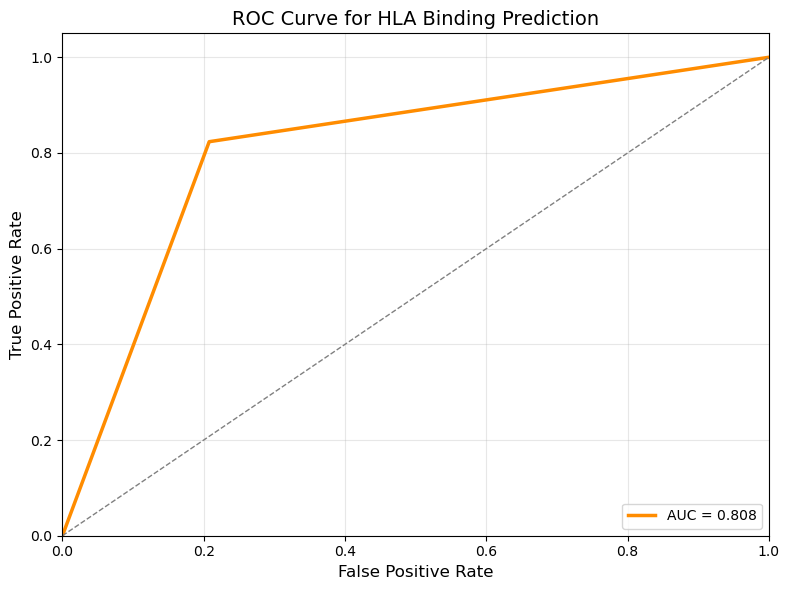

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the data (no header, whitespace-delimited)
data = pd.read_csv("/Users/alberteenglund/Documents/DTU/8_Semester/22125_algorithms_in_bioinformatics/algorithms/BioAlgoProject2025/results/ANN/A0202.res/blosum/hidden.5/epi.0.05/e001.eval", sep="\s+", header=None)

display(data.head())

# Column 2 = predicted score, Column 3 = true label
y_scores = data[3]
y_true = data[4].astype(int)  # <--- Force binary int


display(y_scores, y_true)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2.5, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for HLA Binding Prediction", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
roc_auc = auc(fpr, tpr)
fpr
tpr
thresholds


array([ inf, 0.8 , 0.4 , 0.35, 0.1 ])

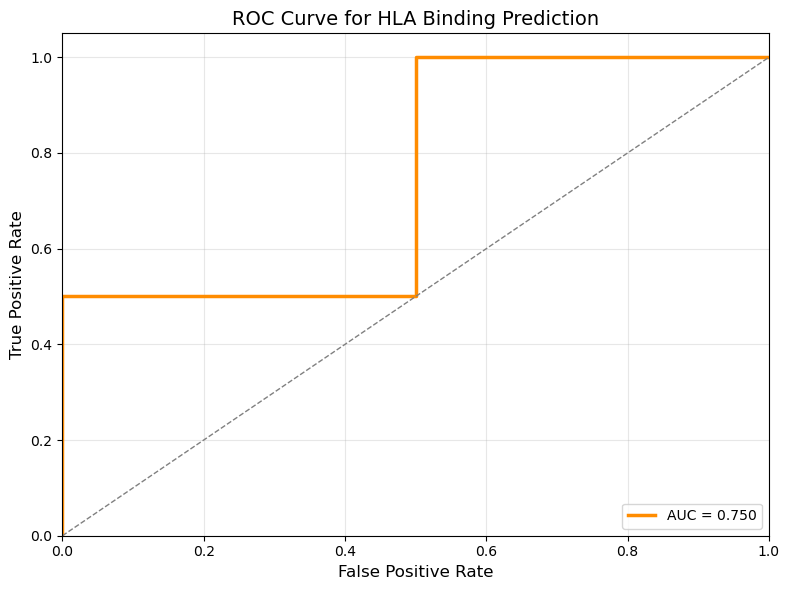

In [11]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2.5, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for HLA Binding Prediction", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()